In [1]:
import sys, os, pygmt, importlib, re, time
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox      import SeaIceToolbox
from datetime             import timedelta, date, datetime
from pathlib              import Path
from dask.distributed     import Client, LocalCluster
from dask.diagnostics     import ProgressBar
from pyproj               import CRS, Transformer
from collections          import defaultdict
from scipy.interpolate    import interp1d
from matplotlib.offsetbox import AnchoredOffsetbox, VPacker, TextArea
import numpy                as np
import pandas               as pd
import xarray               as xr
import xesmf                as xe
import matplotlib.pyplot    as plt
import matplotlib.dates     as mdates
import matplotlib.animation as animation
from IPython.display      import Image, HTML, Video
import warnings
warnings.filterwarnings(
    "ignore",
    message="Sending large graph of size",
    category=UserWarning,
    module="distributed.client"
)

In [ ]:
import sys
import importlib
# Step 1: Clear all relevant modules
for mod in list(sys.modules):
    if mod.startswith("sea_ice_toolbox") or mod.startswith("sea_ice_"):
        del sys.modules[mod]
# Step 2: Explicit reloads in dependency order
import sea_ice_plotter
import sea_ice_classification
import sea_ice_icebergs
import sea_ice_observations
import sea_ice_metrics
import sea_ice_toolbox
importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
importlib.reload(sea_ice_toolbox)
importlib.reload(pygmt)
# Step 3: Re-import key class from module (to refresh the class definition)
from sea_ice_toolbox import SeaIceToolbox

In [ ]:
import sys, os, pygmt, importlib, re, time
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox      import SeaIceToolbox
from datetime             import timedelta, date, datetime
from pathlib              import Path
from dask.distributed     import Client, LocalCluster
from dask.diagnostics     import ProgressBar
from pyproj               import CRS, Transformer
from collections          import defaultdict
from scipy.interpolate    import interp1d
from matplotlib.offsetbox import AnchoredOffsetbox, VPacker, TextArea
import numpy                as np
import pandas               as pd
import xarray               as xr
import xesmf                as xe
import matplotlib.pyplot    as plt
import matplotlib.dates     as mdates
import matplotlib.animation as animation
from IPython.display      import Image, HTML, Video
import warnings
warnings.filterwarnings(
    "ignore",
    message="Sending large graph of size",
    category=UserWarning,
    module="distributed.client"
)
from scipy.stats import binned_statistic_2d
from tqdm import tqdm

def compute_sea_ice_thickness( hi, aice, tarea , spatial_dim_names=["nj","ni"]):
    mask  = aice > 0.15
    hi    = hi.where(mask)
    aice  = aice.where(mask)
    tarea = tarea.where(mask)
    sia   = (aice*tarea).sum(dim=spatial_dim_names)
    siv   = (hi*tarea).sum(dim=spatial_dim_names)
    return siv/sia

afim_name   = "elps-min"
dt0_str    = "2002-10-01"
dtN_str    = "2012-03-31"
SI_tools   = SeaIceToolbox(sim_name             = afim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
FI_raw, CICE = SI_tools.load_processed_cice( zarr_CICE = True )
FI_bool      = SI_tools.boolean_fast_ice(FI_raw['FI_mask'])
CICE_SO      = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
hi_FI        = CICE_SO['hi'].where(FI_bool)
aice_FI      = CICE_SO['aice'].where(FI_bool)
tarea_SO     = CICE_SO['tarea'].where(FI_bool)
aom2_name   = "AOM2-ERA5"
SI_tools   = SeaIceToolbox(sim_name = aom2_name,
                           dt0_str  = dt0_str,
                           dtN_str  = dtN_str)
_,AOM2     = SI_tools.load_processed_cice( zarr_CICE = True )
AOM2_SO    = AOM2.isel( nj=SI_tools.hemisphere_dict['nj_slice'] )
lon_bins    = np.arange(-180, 181, 0.25)
lat_bins    = np.arange(-90, -49.75, 0.25)
lon_centers = 0.5 * (lon_bins[:-1] + lon_bins[1:])
lat_centers = 0.5 * (lat_bins[:-1] + lat_bins[1:])
# define the directory to search for download files
D_search = Path(Path.home(),"seaice","ESA_CCI","L2P","envisat","sh")
# recursively search the sub-directory for files that match
F_search = "ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-*-fv2.0.nc"
P_found  = sorted(D_search.rglob(F_search))
print(f"the number of found files = {len(P_found)}")
# open all the files using mfdataset ... this will use about 10GB of memory
SIT      = {}
sit_list = []
for f in tqdm(P_found, desc="Gridding ESA-CCI SIT"):
    ds      = xr.open_dataset(f)
    lon_raw = ds['lon'].values
    lat_raw = ds['lat'].values
    sit_raw = ds['sea_ice_thickness'].values
    valid   = np.isfinite(lon_raw) & np.isfinite(lat_raw) & np.isfinite(sit_raw)
    lon     = lon_raw[valid]
    lat     = lat_raw[valid]
    sit     = sit_raw[valid]
    sit_binned, _, _, _ = binned_statistic_2d(lon, lat, sit, statistic='mean', bins=[lon_bins, lat_bins])
    sit_grid = np.transpose(sit_binned)  # shape: (lat, lon)
    if "time" in ds and ds.time.size > 0:
        time_val = pd.to_datetime(ds.time.values[0]).floor("D")
    else:
        # Fallback: try extracting from filename
        time_str = f.name.split("-")[-2]  # e.g. "20021001"
        time_val = pd.to_datetime(time_str, format="%Y%m%d")
    sit_da   = xr.DataArray(sit_grid[np.newaxis, :, :],
                            dims=("time", "y", "x"),
                            coords={"time": [time_val], "y": lat_centers, "x": lon_centers},
                            name="SIT")
    sit_list.append(sit_da)
ESA_SIT_reG = xr.concat(sit_list, dim='time')
ESA_SIT_reG = ESA_SIT_reG.sel(time=~ESA_SIT_reG.get_index("time").duplicated())
SIT['ESA']  = ESA_SIT_reG.sel(time=slice("2002", "2012")).mean(("x", "y"), skipna=True)
sit_list = []
for i in tqdm(range(len(CICE_SO.time)), desc=f"computing SIT for {afim_name}"):
    hi_t     = CICE_SO['hi'].isel(time=i).load()
    aice_t   = CICE_SO['aice'].isel(time=i).load()
    tarea_t  = CICE_SO['tarea'].isel(time=i).load()
    time_val = pd.to_datetime(CICE_SO.time.values[i]).floor('D')
    sit      = compute_sea_ice_thickness( hi_t, aice_t, tarea_t )
    sit_da   = xr.DataArray(sit.expand_dims('time'), dims="time", coords={"time": [time_val]}, name="SIT")
    sit_list.append(sit_da)
SIT[afim_name] = xr.concat(sit_list, dim='time')
sit_list = []
for i in tqdm(range(len(AOM2_SO.time)), desc=f"computing SIT for {aom2_name}"):
    hi_t     = AOM2_SO['hi'].isel(time=i).load()
    aice_t   = AOM2_SO['aice'].isel(time=i).load()
    tarea_t  = AOM2_SO['tarea'].isel(time=i).load()
    time_val = pd.to_datetime(AOM2_SO.time.values[i]).floor('D')
    sit      = compute_sea_ice_thickness( hi_t, aice_t, tarea_t )
    sit_da   = xr.DataArray(sit.expand_dims('time'), dims="time", coords={"time": [time_val]}, name="SIT")
    sit_list.append(sit_da)
SIT[aom2_name] = xr.concat(sit_list, dim='time')
SIT['ESA']     = SIT['ESA'].assign_coords(doy=SIT['ESA'].time.dt.dayofyear)
SIT[afim_name] = SIT[afim_name].assign_coords(doy=SIT[afim_name].time.dt.dayofyear)
SIT[aom2_name] = SIT[aom2_name].assign_coords(doy=SIT[aom2_name].time.dt.dayofyear)
SIT['ESA_clim']= SIT['ESA'].groupby('doy').mean(dim=('time', 'x', 'y'), skipna=True)
SIT[f"{afim_name}_clim"] = SIT[afim_name].groupby('doy').mean(dim=('time'), skipna=True)
SIT[f"{aom2_name}_clim"] = SIT[aom2_name].groupby('doy').mean(dim=('time'), skipna=True)
SIT.to_netcdf(Path(Path.home(),"AFIM_archive",afim_name,"SIT_sh_comps_v2_2002-2012.nc"))
doy_ticks    = [15, 46, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]  # ~mid-month
month_labels = pd.to_datetime(doy_ticks, format='%j').strftime('%b')
plt.figure(figsize=(20,12))
plt.plot(SIT['ESA_clim']['doy'], SIT['ESA_clim'].values, label="ESA-CCI", lw=2)
plt.plot(SIT[f'{afim_name}_clim']['doy'], SIT[f'{afim_name}_clim'].values, label=afim_name, lw=2)
plt.plot(SIT[f'{aom2_name}_clim']['doy'], SIT[f'{aom2_mame}_clim'].values, label=aom2_name, lw=2)
plt.xticks(doy_ticks, month_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Month", fontsize=22)
plt.ylabel("Sea Ice Thickness (m)", fontsize=22)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(Path(SI_tools.D_graph,afim_name,"SIT_comparison_and_ESA-CCI.png"))
plt.show()

In [3]:
SIT_comps = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/elps-min/SIT_elps-min_*.nc")
print(SIT_comps)

<xarray.Dataset> Size: 113kB
Dimensions:    (time: 4018)
Coordinates:
  * time       (time) datetime64[ns] 32kB 2002-01-01 2002-01-02 ... 2012-12-31
Data variables:
    SIT_obs    (time) float64 32kB dask.array<chunksize=(365,), meta=np.ndarray>
    SIT_model  (time) float32 16kB dask.array<chunksize=(365,), meta=np.ndarray>
    SIT_AOM2   (time) float32 16kB dask.array<chunksize=(365,), meta=np.ndarray>
    SIT_CICE   (time) float32 16kB dask.array<chunksize=(365,), meta=np.ndarray>


In [10]:
dt                         = pd.to_datetime(SIT_comps["time"].values)
SIT_comps.coords['doy']    = ('time', dt.dayofyear)
SIT_comps['SIT_obs_clim']  = SIT_comps['SIT_obs'].assign_coords(doy=SIT_comps['doy']).groupby('doy').mean('time')
SIT_comps.coords['doy']    = ('time', dt.dayofyear)
SIT_comps['SIT_AOM2_clim'] = SIT_comps['SIT_AOM2'].assign_coords(doy=SIT_comps['doy']).groupby('doy').mean('time')
SIT_comps.coords['doy']    = ('time', dt.dayofyear)
SIT_comps['SIT_CICE_clim'] = SIT_comps['SIT_CICE'].assign_coords(doy=SIT_comps['doy']).groupby('doy').mean('time')

In [11]:
SIT_comps

<xarray.Dataset> Size: 120kB
Dimensions:        (time: 4018, doy: 366)
Coordinates:
  * time           (time) datetime64[ns] 32kB 2002-01-01 ... 2012-12-31
  * doy            (doy) int32 1kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Data variables:
    SIT_obs        (time) float64 32kB dask.array<chunksize=(365,), meta=np.ndarray>
    SIT_model      (time) float32 16kB dask.array<chunksize=(365,), meta=np.ndarray>
    SIT_AOM2       (time) float32 16kB dask.array<chunksize=(365,), meta=np.ndarray>
    SIT_CICE       (time) float32 16kB dask.array<chunksize=(365,), meta=np.ndarray>
    SIT_obs_clim   (doy) float64 3kB dask.array<chunksize=(366,), meta=np.ndarray>
    SIT_AOM2_clim  (doy) float32 1kB dask.array<chunksize=(366,), meta=np.ndarray>
    SIT_CICE_clim  (doy) float32 1kB dask.array<chunksize=(366,), meta=np.ndarray>

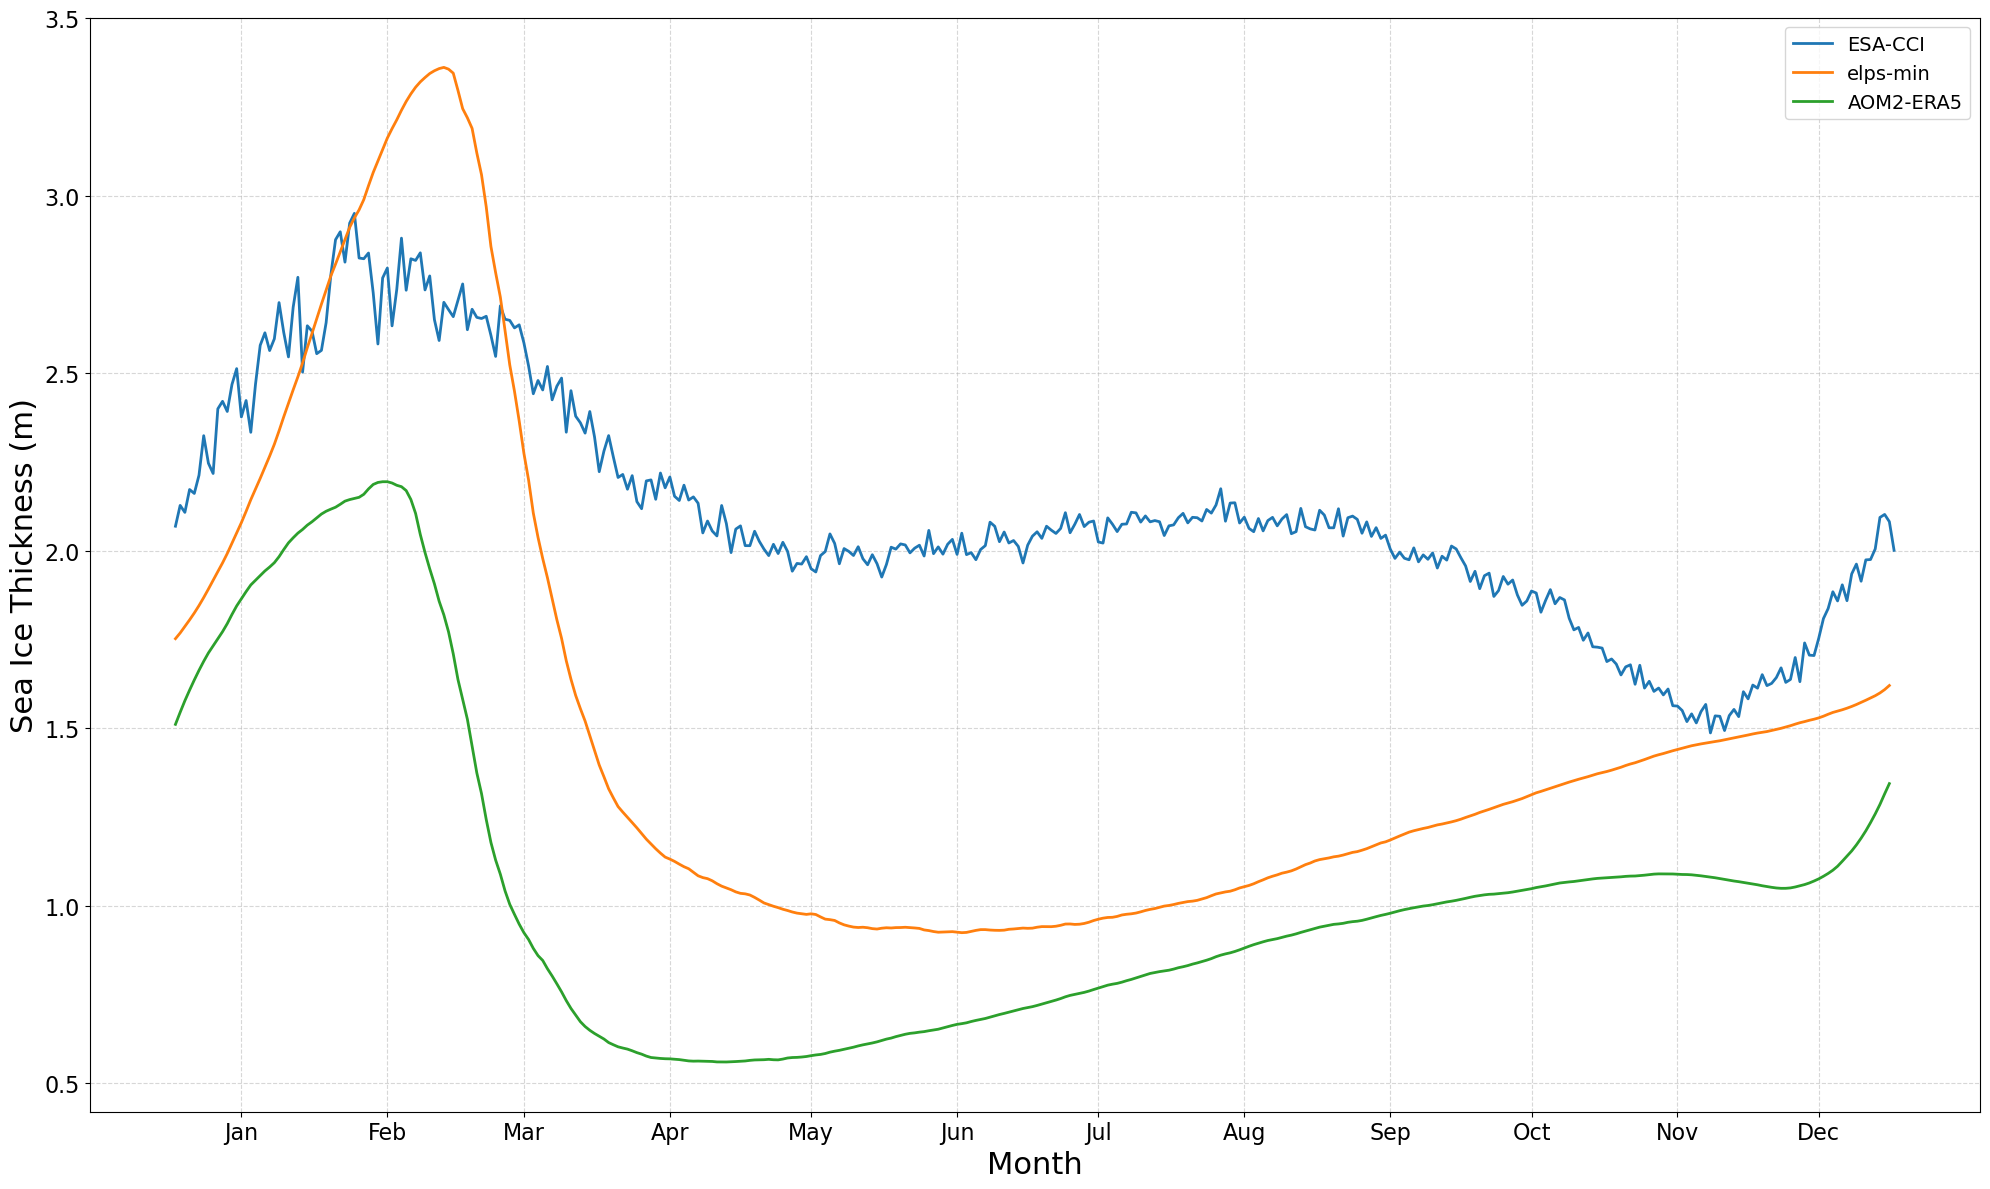

In [15]:
doy_ticks = [15, 46, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]  # ~mid-month
month_labels = pd.to_datetime(doy_ticks, format='%j').strftime('%b')
plt.figure(figsize=(20,12))
plt.plot(SIT_comps['doy'], SIT_comps['SIT_obs_clim'].values, label="ESA-CCI", lw=2)
plt.plot(SIT_comps['doy'], SIT_comps['SIT_CICE_clim'].values, label="elps-min", lw=2)
plt.plot(SIT_comps['doy'], SIT_comps['SIT_AOM2_clim'].values, label="AOM2-ERA5", lw=2)
plt.xticks(doy_ticks, month_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Month", fontsize=22)
plt.ylabel("Sea Ice Thickness (m)", fontsize=22)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(Path(Path.home(),"graphical","AFIM","elps-min", "SIT_comparison_and_ESA-CCI.png"))
plt.show()

In [ ]:
P_ESA_CCI_reG           = Path(Path.home(),"seaice","ESA_CCI","L2P","envisat","sh","reG","ESA_CCI_SIT_regridded.zarr")
ESA_CCI                 = xr.open_zarr(P_ESA_CCI_reG)
dt                      = pd.to_datetime(ESA_CCI["time"].values)
ESA_CCI.coords['doy']   = ('time', dt.dayofyear)
ESA_CCI['ESA_sit_clim'] = ESA_CCI['ESA_sit'].groupby('doy').mean('time')

  # or use `.isel(doy=slice(None)).any('doy')`

In [ ]:
def compute_doy_climatology(da):
    doy = da['time'].dt.dayofyear
    return da.groupby(doy).mean(dim='time', skipna=True)
hi_SO['doy'] = hi_SO.assign_coords(doy=hi_SO['time'].dt.dayofyear)
hi_SO        = hi_SO.chunk({'time': 1, 'nj': 540, 'ni': 720})
hi_SO_clim   = compute_doy_climatology(hi_SO)

sit_CICE_df  = pd.DataFrame({"longitude": CICE_SO.TLON.values.flatten(), "latitude": CICE_SO.TLAT.values.flatten(), "z": hi_SO_clim.isel(dayofyear=180).values.flatten()})
sit_CICE_reG = pygmt.nearneighbor(data=sit_CICE_df, region=[0, 360, -90, -50], spacing="0.25/0.25", search_radius="10k")
sit_CICE_da  = xr.DataArray(sit_CICE_reG.values, coords={"lat": sit_CICE_reG.lat.values, "lon": sit_CICE_reG.lon.values}, dims=("lat", "lon"))


hi_AOM2['doy'] = hi_AOM2.assign_coords(doy=hi_AOM2['time'].dt.dayofyear)
hi_AOM2        = hi_AOM2.chunk({'time': 1, 'nj': 540, 'ni': 720})
hi_AOM2_clim   = compute_doy_climatology(hi_AOM2)
sit_AOM2_df    = pd.DataFrame({"longitude": AOM2_SO.TLON.values.flatten(), "latitude": AOM2_SO.TLAT.values.flatten(), "z": hi_AOM2_clim.isel(dayofyear=180).values.flatten()})
sit_AOM2_reG   = pygmt.nearneighbor(data=sit_AOM2_df, region=[0, 360, -90, -50], spacing="0.25/0.25", search_radius="10k")
sit_AOM2_da    = xr.DataArray(sit_AOM2_reG.values, coords={"lat": sit_AOM2_reG.lat.values, "lon": sit_AOM2_reG.lon.values}, dims=("lat", "lon"))

In [ ]:
ESA_CCI_reG = xr.open_dataset("/home/581/da1339/seaice/ESA_CCI/ESA_CCI_L2P_envisat_SH_SIT_SIV_daily.nc")

In [ ]:
def compute_doy_climatology(da):
    return da.groupby(da['time'].dt.dayofyear).mean(dim='time', skipna=True)
def regrid_to_common_grid(lon, lat, z, region=[0, 360, -90, -50], spacing="0.25/0.25", search_radius="10k"):
    df = pd.DataFrame({"longitude": lon.flatten(), "latitude": lat.flatten(), "z": z.flatten()})
    df = df.dropna()
    result = pygmt.nearneighbor(data=df, region=region, spacing=spacing, search_radius=search_radius)
    return xr.DataArray(result.values, coords={"lat": result.lat.values, "lon": result.lon.values}, dims=("lat", "lon"))

# CICE
hi_SO = hi_SO.chunk({'time': 1, 'nj': 540, 'ni': 720})
hi_SO_clim = compute_doy_climatology(hi_SO)

# AOM2
hi_AOM2 = hi_AOM2.chunk({'time': 1, 'nj': 540, 'ni': 720})
hi_AOM2_clim = compute_doy_climatology(hi_AOM2)

# ESA (already climatology from file)
sit_ESA = ESA_CCI_reG['SIT_clim']  # dims: doy, y, x


In [ ]:
from sklearn.metrics import mean_squared_error

metrics = []
reG_sit = {'CICE': [], 'AOM2': [], 'ESA': []}
sit_sum = {'CICE': [], 'AOM2': [], 'ESA': []}

for doy in range(1, 366):
    print(f"\nProcessing DOY: {doy}")
    
    # Extract daily slices
    cice = hi_SO_clim.sel(dayofyear=doy).values
    aom2 = hi_AOM2_clim.sel(dayofyear=doy).values
    esa  = sit_ESA.sel(doy=doy).values

    # Regrid all to common lat/lon
    cice_regrid = regrid_to_common_grid(CICE_SO.TLON.values, CICE_SO.TLAT.values, cice)
    aom2_regrid = regrid_to_common_grid(AOM2_SO.TLON.values, AOM2_SO.TLAT.values, aom2)
    X, Y        = np.meshgrid(sit_ESA.x.values, sit_ESA.y.values)
    esa_regrid  = regrid_to_common_grid(X, Y, esa, search_radius="100k")

    # Store the regridded SIT for future use
    reG_sit['CICE'].append(cice_regrid.expand_dims(doy=[doy]))
    reG_sit['AOM2'].append(aom2_regrid.expand_dims(doy=[doy]))
    reG_sit['ESA'].append(esa_regrid.expand_dims(doy=[doy]))

    # Apply combined valid mask
    valid_mask = ~np.isnan(esa_regrid) & ~np.isnan(cice_regrid) & ~np.isnan(aom2_regrid)
    n_valid = valid_mask.sum().item()
    print(f"Number of valid points: {n_valid}")

    if n_valid < 10:
        print(f"Less than 10 valid data points for DOY {doy} ... skipping")
        continue

    # Flatten valid values
    esa_valid = esa_regrid.values[valid_mask]
    cice_valid = cice_regrid.values[valid_mask]
    aom2_valid = aom2_regrid.values[valid_mask]

    # Spatial sums (sea ice volume proxy)
    sit_sum['CICE'].append((doy, cice_valid.sum().mean()))
    sit_sum['AOM2'].append((doy, aom2_valid.sum().mean()))
    sit_sum['ESA'].append((doy, esa_valid.sum().mean()))

    # Metrics
    rmse_cice = mean_squared_error(esa_valid, cice_valid)
    rmse_aom2 = mean_squared_error(esa_valid, aom2_valid)
    corr_cice = np.corrcoef(esa_valid, cice_valid)[0, 1]
    corr_aom2 = np.corrcoef(esa_valid, aom2_valid)[0, 1]

    metrics.append({
        "DOY": doy,
        "RMSE_CICE": rmse_cice,
        "Corr_CICE": corr_cice,
        "RMSE_AOM2": rmse_aom2,
        "Corr_AOM2": corr_aom2,
        "N": len(esa_valid)
    })

# Create 3D regridded DataArrays
reG_ds = xr.Dataset({
    "ESA": xr.concat(reG_sit["ESA"], dim="doy"),
    "CICE": xr.concat(reG_sit["CICE"], dim="doy"),
    "AOM2": xr.concat(reG_sit["AOM2"], dim="doy"),
})
reG_ds.to_netcdf(Path(Path.home(), "AFIM_archive", "elps-min", "ESA-CCI_daily_SIT_regrid.nc"))

# Create 1D SIT sums
sit_df = pd.DataFrame({
    "DOY": [d for d, _ in sit_sum["ESA"]],
    "ESA_sum": [s for _, s in sit_sum["ESA"]],
    "CICE_sum": [s for _, s in sit_sum["CICE"]],
    "AOM2_sum": [s for _, s in sit_sum["AOM2"]],
})
sit_df = sit_df.set_index("DOY")
sit_ds = sit_df.to_xarray()
sit_ds.to_netcdf(Path(Path.home(), "AFIM_archive", "elps-min", "ESA-CCI_daily_SIT_sum.nc"))

# Metrics dataset
df_metrics = pd.DataFrame(metrics).set_index("DOY")
ds_metrics = df_metrics.to_xarray()
ds_metrics["RMSE_CICE"].attrs = {
    "units": "unitless",
    "long_name": "Root Mean Square Error - CICE model"
}
ds_metrics["Corr_CICE"].attrs = {
    "units": "1",
    "long_name": "Pearson Correlation Coefficient - CICE model"
}
ds_metrics["RMSE_AOM2"].attrs = {
    "units": "unitless",
    "long_name": "Root Mean Square Error - AOM2 model"
}
ds_metrics["Corr_AOM2"].attrs = {
    "units": "1",
    "long_name": "Pearson Correlation Coefficient - AOM2 model"
}
ds_metrics["N"].attrs = {
    "units": "count",
    "long_name": "Number of spatial grid points used"
}
ds_metrics.attrs = {
    "title": "Daily Model Skill Metrics",
    "summary": "Daily statistics comparing CICE and AOM2 model outputs against ESA-CCI observations.",
    "Conventions": "CF-1.8",
    "source": "Generated using xarray from Python",
    "author": "Dan Atwater",
}
ds_metrics.to_netcdf(Path(Path.home(), "AFIM_archive", "elps-min", "ESA-CCI_daily_metrics.nc"))

print("All NetCDF files written successfully.")


In [ ]:
# Plot RMSE comparison
plt.figure(figsize=(10, 5))
plt.plot(ds.DOY, ds.RMSE_CICE, label="RMSE - CICE")
plt.plot(ds.DOY, ds.RMSE_AOM2, label="RMSE - AOM2")
plt.xlabel("Day of Year")
plt.ylabel("RMSE")
plt.title("Daily RMSE for CICE and AOM2 Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Correlation comparison
plt.figure(figsize=(10, 5))
plt.plot(ds.DOY, ds.Corr_CICE, label="Correlation - CICE")
plt.plot(ds.DOY, ds.Corr_AOM2, label="Correlation - AOM2")
plt.xlabel("Day of Year")
plt.ylabel("Correlation Coefficient")
plt.title("Daily Correlation for CICE and AOM2 Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
reG_ds['ESA'].isel(doy=180).plot()

In [ ]:
reG_ds['CICE'].isel(doy=180).plot()

In [ ]:
sim_name = "elps-min"
#for region in SI_tools.Ant_8sectors.keys():
SI_tools = SeaIceToolbox(sim_name=sim_name)
D_png = Path(SI_tools.D_graph, sim_name, "south", "hi")
D_ani = Path(SI_tools.D_graph, "animations", sim_name, "hi")
F_ani = f"{sim_name}_hi_south.mp4"
P_ani = Path(D_ani,F_ani)
P_mp4 = Path.home() / "AFIM" / "src" / "AFIM" / "docs" / "figures" / F_ani
D_ani.mkdir(parents=True, exist_ok=True)
frames = sorted([f for f in os.listdir(D_png) if f.endswith(".png")])
os.system(f"rm {SI_tools.D_tmp}/frame_*.png")
for i, f in enumerate(frames):
    src = D_png / f
    dst = Path(SI_tools.D_tmp) / f"frame_{i:04d}.png"
    if not dst.exists():
        os.symlink(src, dst)
os.system(f"ffmpeg -y -r 2 -i {SI_tools.D_tmp}/frame_%04d.png -vf \"scale=iw:ih+mod(2-ih\\,2)\" -c:v libx264 -pix_fmt yuv420p {P_ani}")
os.system(f"cp {P_ani} {P_mp4}")

In [ ]:
CICE_SO     = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
sim_name    = "AOM2-ERA5"
dt0_str     = "1993-01-01"
dtN_str     = "1999-12-31"
SI_tools    = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
DS, AOM2    = SI_tools.load_processed_cice(zarr_CICE = True)
AOM2_SO     = AOM2.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
OSI_SAF     = xr.open_mfdataset("/home/581/da1339/seaice/OSI_SAF/ispd_reG_SH*")

In [ ]:
AOM2_ispd   = SI_tools.compute_ice_magnitude_from_ice_components_on_Bgrid(AOM2, ivec_type = 'BT')
CICE_ispd   = SI_tools.compute_ice_magnitude_from_ice_components_on_Bgrid(CICE, ivec_type = 'BT')

In [ ]:
from PIL import Image
def stitch_fip_side_by_side(sim_model, sim_obs, base_dir, region_list, output_path, dpi=200):
    nrows = len(region_list)
    fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(20,60))
    for row, region in enumerate(region_list):
        for col, sim in enumerate([sim_obs, sim_model, "FIP_delta"]):  # left: obs, right: model
            if col==2:
                path = os.path.join(base_dir, sim_model, region, "FIP_delta", f"2000-2018_{sim_model}_{region}_FIP_delta.png")
            else:
                path = os.path.join(base_dir, sim, region, "FIP", f"2000-2018_{sim}_{region}_FIP.png")
            if not os.path.exists(path):
                print(f"❌ Missing: {path}")
                axs[row, col].axis("off")
                continue
            img = Image.open(path)
            axs[row, col].imshow(img)
            axs[row, col].axis("off")
    axs[0, 0].set_title("AF2020 (obs)"       , fontsize=14, fontweight="bold")
    axs[0, 1].set_title(f"{sim_model} (sim)" , fontsize=14, fontweight="bold")
    axs[0, 2].set_title("Difference: obs-sim", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(output_path, dpi=dpi)
    plt.close()
    print(f"✅ Saved stitched figure: {output_path}")
region_list = ["DML", "WIO", "EIO", "Aus", "VOL", "AS", "BS", "WS"]
stitch_fip_side_by_side("elps-min", "AF20",
                  base_dir="/g/data/gv90/da1339/GRAPHICAL/AFIM",
                  region_list=region_list,
                  output_path="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIP_panel_AF20_vs_elps-min.png")